# **Introduction**
Heart disease is caused by the buildup of cholesterol and other substances on the walls of the arteries that supply blood to the heart. This buildup will cause the inside of the arteries to narrow over time which can lead to heart attacks or heart failure. Heart disease is thought to be present when the diameter of the arteries have narrowed by more than 50% over time. Some common risk factors for heart disease are high blood pressure, high cholesterol and aging.

We will be using a heart disease dataset from Cleveland that has information on 303 patients with 14 columns of various medical information to try and predict an individual's diagnosis of heart disease. The class we're predicting is whether or not heart disease is present in the individual based on how much the diameter of their arteries have narrowed.

## Question
What is the diagnosis of heart disease of an individual from Cleveland?

## Sources
https://www.cdc.gov/heartdisease/coronary_ad.htm

# **Exploratory Data Analysis**

In [19]:
#Install cowplot to use plot_grid function for better readability (optional) 
install.packages('cowplot')

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [20]:
library(tidyverse)
library(tidymodels)
library(cowplot)

## Reading the Data

In [21]:
#Read the data from the webpage into Jupyter
heart_disease <- read_delim("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", col_names = FALSE)
#Add column names based on the information given by the dataset webpage (to improve readability)
colnames(heart_disease) <- c("age", "sex", "chest_pain_type", "resting_blood_pressure", "chol", "fasting_blood_sugar", "resting_electrocardiographic_results", "maximum_heart_rate_achieved", "exercise_induced_angina", "ST_level", "slope", "number_of_major_vessels", "thal", "diagnosis_of_heart_disease")
#Select chosen predictor and class variables 
heart_data <- heart_disease |> mutate(diagnosis = as_factor(diagnosis_of_heart_disease)) |> select(age, resting_blood_pressure, chol, ST_level, diagnosis)
#Check to see if there are any NA values
which(is.na(heart_data))
    #There aren't any NA values (the function returned no positions with missing values)

head(heart_data, n =8)


Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


integer(0)

age,resting_blood_pressure,chol,ST_level,diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,145,233,2.3,0
67,160,286,1.5,2
67,120,229,2.6,1
37,130,250,3.5,0
41,130,204,1.4,0
56,120,236,0.8,0
62,140,268,3.6,3
57,120,354,0.6,0


We can wrangle our data so that the diagnosis is binary. From information given by the dataset, we know that any value greater than 0 in diagnosis means that there is heart disease present, we can group all values 1 to 4 as "1". Finally, we can split our data into training and testing data.

In [22]:
#Assign all values, 1-4, as "1" to indicate that there is a heart disease
heart_data["diagnosis"][heart_data["diagnosis"] == "2"] <- "1"
heart_data["diagnosis"][heart_data["diagnosis"] == "3"] <- "1"
heart_data["diagnosis"][heart_data["diagnosis"] == "4"] <- "1"

#Split data into training and testing data; 75:25 split was chosen arbitrarily
heart_split <- initial_split(heart_data, prop = 0.75, strata = diagnosis)  
heart_train <- training(heart_split)   
heart_test <- testing(heart_split)

## Data Summary

In [30]:
#Find the number of observations for each class (heart disease = 1 or no heart disease = 0) as well as the mean of each predictor
heart_summary <- heart_train |> group_by(diagnosis) |> summarize(number_of_observations = n(), mean_bp = mean(resting_blood_pressure), mean_chol = mean(chol), mean_st = mean(ST_level))
heart_summary

diagnosis,number_of_observations,mean_bp,mean_chol,mean_st
<fct>,<int>,<dbl>,<dbl>,<dbl>
0,123,130.3902,241.3821,0.6186992
1,104,136.1250,254.1538,1.5865385


From this table, we see that the number of observations for each diagnosis are roughly equal. There also appears to be a difference between means of predictors of the different diagnosis.

## Data Visualization

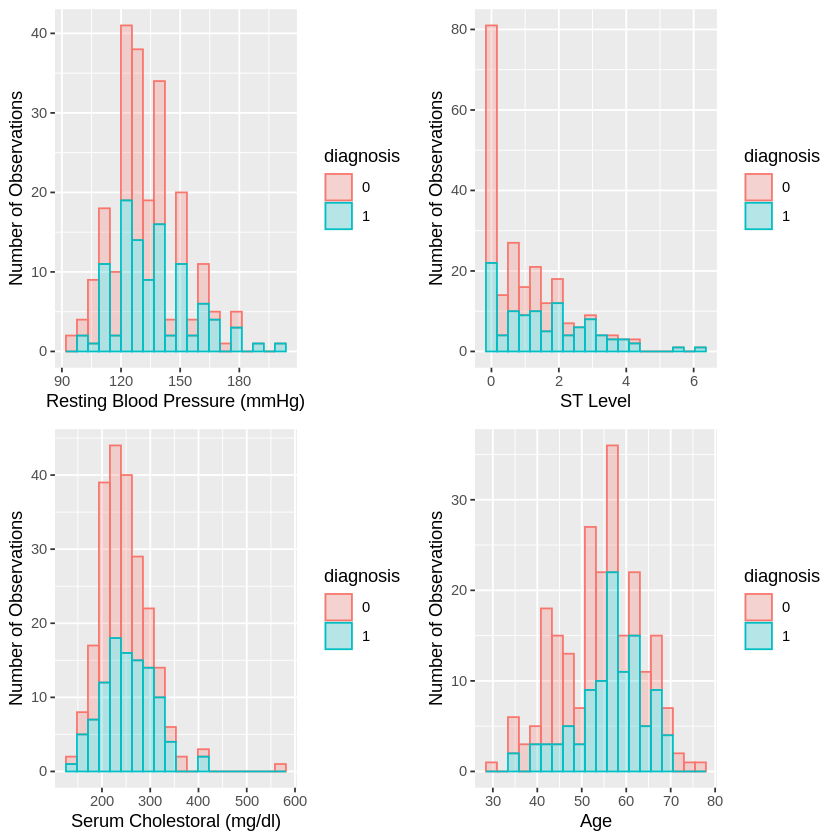

In [32]:
#Plot the distributions of each predictor
    #Note that each plot only considers one factor and may also be influenced by other factors 
bp_distribution <- ggplot(heart_train, aes(x = resting_blood_pressure, fill = diagnosis, colour = diagnosis)) + geom_histogram(bins = 20,alpha = 0.25) + labs(x = "Resting Blood Pressure (mmHg)", y = "Number of Observations")
                     
chol_distribution <- ggplot(heart_train, aes(x = chol, fill = diagnosis, colour = diagnosis)) + geom_histogram(bins = 20, alpha = 0.25) + labs(x ="Serum Cholestoral (mg/dl)", y = "Number of Observations")

age_distribution <- ggplot(heart_train, aes(x = age, fill = diagnosis, colour = diagnosis)) + geom_histogram(bins = 20,alpha = 0.25) + labs(x= "Age", y = "Number of Observations")

st_distribution <- ggplot(heart_train, aes(x = ST_level, fill = diagnosis, colour = diagnosis)) + geom_histogram(bins = 20, alpha = 0.25) + labs(x = "ST Level", y = "Number of Observations")

plot_grid(bp_distribution, st_distribution, chol_distribution, age_distribution)

# **Methods**

## Predictors

We chose the variables which are known to have a correlation with heart disease.

- Resting blood pressure
    
    Elevated blood pressures indicate an increased risk of hypertension, which is indicative of many heart diseases. 

- Cholesterol levels

    High cholesterol results in fatty deposits in blood vessels which can lead to heart diseases.
    
- Age

    Aging can cause changes in the heart and blood vessels that may increase a person's risk of developing heart disease. 
    
- ST Levels

   ST levels are a segment of an ECG (electrocardiogram) reading; elevated ST levels are usually indicative of heart disease. 

(Diagrams below are for clarification)



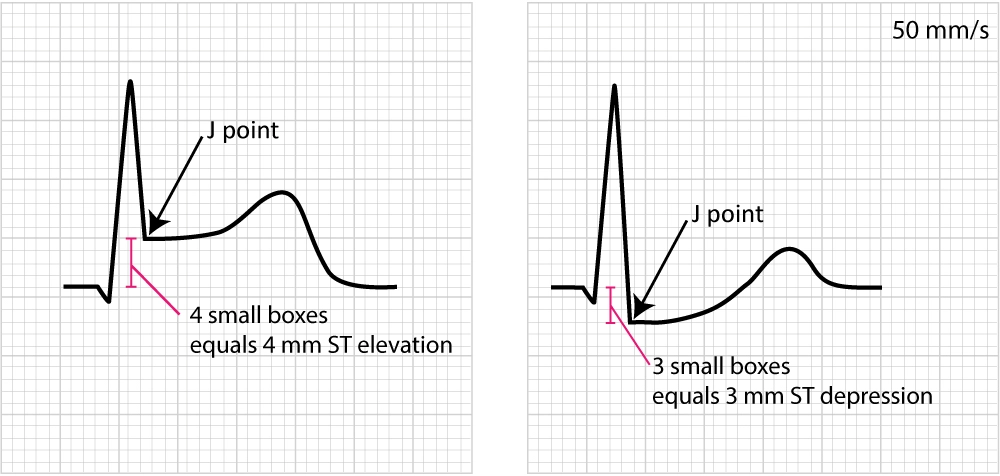


ST Levels on ECG monitor.


Source: https://ecgwaves.com/st-segment-normal-abnormal-depression-elevation-causes/

# Methodology

Since our data is not too large and our classes are roughly equal, KNN Classification will be used to predict a categorical variable based on similar measures of existing data points.

### 1. Create KNN Model

Using the predictors listed above, we will create a KNN model to be fitted with our training data with `tidymodels`. We will need to scale our variables for the model.

### 2. Identify Optimal Value of $K$
We can use `vfold_cv` cross-validation to calculate an accuracy for each value of $K$ in a reasonable range, and pick the value that gives us the best accuracy. 

### 3. Create Final Model
Using the best $K$ value, we can create a final KNN model to be used to predict the diagnosis of heart disease on new data.

### 4. Evaluate Accuracy
With the `predict` function, we can evaluate our accuracy using our testing data.

### 5. Visualizing Results
We can use the following to help visualize the relationship between our predictors and class:

- HISTOGRAM

    Visualize differences in distribution of predictors between each class.
    
- SCATTERPLOT
    Visualize the correlation between predictors and class.

We will be plotting two predictors at a time, differentiating the data by class (i.e., heart disease diagnosis).
    

# **Conclusion**

We expect that as age, cholesterol, resting blood pressure and ST level increases, so will the prevalence of heart disease. Thus, the presence of a heart disease could be predicted by evaluating these health factors.

If the model can predict heart disease with high accuracy it means it could serve as a tool in the diagnosis of heart disease, but questions like the following remain:

Can other health factors help better predict the presence of heart disease within a patient? 
Should preventative measures be taken for high-risk individuals based on these predictors?